# Import Libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import glob
import matplotlib.dates as mdates
import os
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from datetime import timedelta
from matplotlib.ticker import ScalarFormatter, LogLocator
from matplotlib.ticker import FuncFormatter, LogLocator
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, LogFormatter
from scipy.stats import zscore
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import pytz
import matplotlib.ticker as ticker

# Set Plotting Parameters

Fontsize, linewidth, etc. Feel free to change these as you wish

In [2]:
np.set_printoptions(precision = 4)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = '1.5'
mpl.rcParams['ytick.major.width'] = '1.5'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.major.size'] = '10.0'
mpl.rcParams['ytick.major.size'] = '10.0'
mpl.rcParams['xtick.minor.size'] = '5.0'
mpl.rcParams['ytick.minor.size'] = '5.0'
mpl.rcParams['axes.linewidth'] = '1.5'
mpl.rcParams['axes.labelsize'] = '20'
mpl.rcParams['axes.titlesize'] = '20' 
mpl.rcParams['figure.titlesize'] = '20'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

# Define paths

In [3]:
# Path to SMPS data file (the cleaned_csv saved at the end of code in cleaning_smps_csv_VIB.ipynb)
pathp = 'C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/smps_full_dataset_2023-08-04_to_2025-08-25.csv'

# # Path to folder in which you keep your Aethelometer csv files
# aeth_path = '/Users/vineblankenship/Research/ASCENT/AETHDataSummer2025'
#
# # Path to individual Aethelometer csv files for the concatenation step
# aeth_csv_files = glob.glob(aeth_path  + '/*.csv')

# output_folder is the destination folder of all of the plots below
output_folder = 'C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output'


# Define the dataframe as dfp (short for DataFrame Pico Rivera, in this case)

Load in the csv from the SMPS path defined above and define a time series dataframe for which the local_time column is the index 

In [4]:
dfp = pd.read_csv(pathp)

In [5]:
tsdfp = dfp.set_index('local_time')
tsdfp = tsdfp.sort_index()

# Locate Relevant Concentration Columns (This varies site to site and it is different for Shiny csv files versus csv files downloaded locally at sites)

In [6]:
tsdfp.columns[41:156] # your column range here

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Define the concentration_columns range as the range you have selected above

In [7]:
concentration_columns = slice(41, 156) # your column range here

# Calculations from original ASCENT SMPS code: 

Calculating dN/dlogDp at standard temperature and pressure (STP) 

In [8]:
# read diameter as array
mid_Dp = np.array([float(x) for x in tsdfp.columns[concentration_columns]]) # pico
avg_diffp = np.mean(np.diff(np.log10(mid_Dp)))

D_boundp = np.full(mid_Dp.shape[0]+1, np.nan)
for i in range (1, (len(D_boundp)-1)):
    D_boundp[i] = 10 ** (0.5 * (np.log10(mid_Dp[i])+np.log10(mid_Dp[i-1])))
    
D_boundp[0] = 10 ** (np.log10(mid_Dp[0]) - 0.5*avg_diffp)
D_boundp[-1] = 10 ** (np.log10(mid_Dp[-1]) + 0.5*avg_diffp)
D_lowp = D_boundp[0:-1]
D_highp = D_boundp[1:]
dlogDpp = np.log10(D_highp) - np.log10(D_lowp)

In [9]:
# STP conversion factor
STP_factorp = (101.35/tsdfp['Sheath Pressure (kPa)']) * ((273.15+tsdfp['Sheath Temp (C)'])/273.15)

In [10]:
# Check the column indices to ensure you run the calculations on the concentrations 
tsdfp.columns[concentration_columns]

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Define dNdlogDp_stpp, dVdlogDp_stpp, dMdlogDp_stpp, N_stp, V_stp, M_stp

In [12]:
# calculate total number of each scan 
artsdfp = np.array(tsdfp)

dNdlogDpp = artsdfp[:, concentration_columns] # pico

dNdlogDp_stpp = dNdlogDpp * np.array(STP_factorp)[:,None]

dN_stpp = dNdlogDp_stpp * dlogDpp

N_stp = np.nansum(dN_stpp, axis=1)

# # calculate volume distribution and total volume of each scan 
dVdlogDp_stpp = (np.pi/6.) * (mid_Dp/1e3) **3 * dNdlogDp_stpp  #um3/cm3

dV_stpp = dVdlogDp_stpp * dlogDpp

V_stp = np.nansum(dV_stpp, axis=1)         #um3/cm3

# calculate mass distribution and total mass of each scan by assuming a particle density
density = 1.0      #  g/cm³
dMdlogDp_stpp = (density/1e9) * (np.pi/6.) * mid_Dp**3 * dNdlogDp_stpp    #ug/m3

dM_stp = dMdlogDp_stpp * dlogDpp

M_stp = np.nansum(dM_stp, axis=1)         #ug/m3

print(dM_stp.shape)

(431271, 115)


In [13]:
dNdlogDp_stpp.shape

(431271, 115)

In [14]:
# Add N_stp array to the corresponding DataFrame
dfp['N_stp'] = N_stp


C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_38648\1773031517.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp['N_stp'] = N_stp


# Add Black Carbon Data

## Concatenate all csv files in a folder for Aethelometer data

In [14]:
# concatenate
df_list = (pd.read_csv(file) for file in aeth_csv_files)

# Concatenate all DataFrames
dfb   = pd.concat(df_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
dfb['time'] = pd.to_datetime(dfb['time'], format='%Y-%m-%d %H:%M:%S')

/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_65244/3160888105.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in aeth_csv_files)


## Convert to local time

In [15]:
def convert_to_local(df):

    dfb_local = df.copy()

    # Local timezone (replace with your local timezone)
    source_timezone = pytz.timezone('UTC')
    local_timezone = pytz.timezone('America/Los_Angeles')

    # Use the tz_convert function to convert the datetime column
    dfb_local['time'] = df['time'].dt.tz_localize(source_timezone).dt.tz_convert(local_timezone)
    dfb_local['time'] = pd.to_datetime(dfb_local["time"].dt.strftime('%Y-%m-%d %H:%M:%S'))

    dfb_local.rename(columns={'time':'local_time_bc'}, inplace=True)
    return dfb_local

## Call the local time conversion function, convert_to_local, to get the new df, dfb_local, which has the aethelometer data now in local time

In [16]:
dfb_local = convert_to_local(dfb)

Calculate the rolling 30 minute average of the vehicular black carbon concentration (EBC_6 in aethelometer data)

Make a merged dataframe which contains both SMPS and Aethelometer data across consistent timestamps

Add a column to the original SMPS dataframe which represents the rolling 30 minute average black carbon, here titled 30_min_avg (from the column EBC_6 in aethelometer data) 

In [17]:


# --- Step 1: Ensure datetime and set index for rolling calculation ---
dfb_local['local_time_bc'] = pd.to_datetime(dfb_local['local_time_bc'])
dfb_local = dfb_local.sort_values('local_time_bc').set_index('local_time_bc')

# --- Step 2: Calculate rolling 30-min average for EBC_6 ---
dfb_local['30_min_avg'] = dfb_local['EBC_6'].rolling('30T').mean()

# --- Step 3: Reset index so local_time_bc is a column again ---
dfb_local = dfb_local.reset_index()

# --- Step 4: Ensure dfp datetime is correct ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])

# --- Step 5: Merge using merge_asof ---
merged_df = pd.merge_asof(
    dfp.sort_values('local_time'),
    dfb_local[['local_time_bc', '30_min_avg']].sort_values('local_time_bc'),
    left_on='local_time',
    right_on='local_time_bc',
    direction='nearest',
    suffixes=('', '_bc')  # avoid naming conflicts
)


# --- Step 6: Add the rolling average column to dfp ---
if '30_min_avg' in merged_df.columns:
    dfp['30_min_avg'] = merged_df['30_min_avg']
else:
    raise KeyError("⚠ '30_min_avg' not found in merged_df. Check dfb_local generation.")

print(dfp[['local_time', '30_min_avg']].head())

           local_time  30_min_avg
0 2025-05-31 17:02:06    0.000000
1 2025-05-31 17:04:38   -0.140600
2 2025-05-31 17:07:10   -0.203875
3 2025-05-31 17:09:41   -0.242800
4 2025-05-31 17:12:12   -0.094462


/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_65244/3369010147.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dfb_local['30_min_avg'] = dfb_local['EBC_6'].rolling('30T').mean()


In [96]:
dfp # can check to ensure 30_min_avg column was added to dfp here

,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),Impactor D50 (nm),...,716.92,729.93,743.18,756.67,770.40,784.39,798.63,N_stp,date,weekday
local_time,,,,,,,,,,,,,,,,,,,,,
2024-04-29 16:54:05,1.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.01,0.010,77.447,0.010,50.340,20426.729396,2024-04-29,Monday
2024-04-29 16:56:36,2.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,113.676,0.010,0.01,87.634,0.010,0.010,0.010,19611.537540,2024-04-29,Monday
2024-04-29 16:59:07,3.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.01,0.010,0.010,65.270,0.010,18561.307395,2024-04-29,Monday
2024-04-29 17:01:38,4.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.01,27.503,54.441,0.010,0.010,18358.708614,2024-04-29,Monday
2024-04-29 17:04:09,5.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,91.279,0.01,0.010,0.010,0.010,54.446,16522.334172,2024-04-29,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-17 09:59:19,4646.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.01,86.910,0.010,64.143,97.486,7846.762205,2024-07-17,Wednesday
2024-07-17 10:01:50,4646.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.01,86.897,76.369,64.143,0.010,7392.949973,2024-07-17,Wednesday
2024-07-17 10:01:50,4696.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.01,86.529,75.956,63.651,0.010,7404.495045,2024-07-17,Wednesday


# Plotting Section 

## Time series colormap plot for every day in the dataset (x=time, y=diameter (nm), z=dNdlogDp)

Here, I use a warped colormap (a cubic function instead of linear) which emphasizes the variation in the high concentrations

C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32112\2831362525.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp['date'] = dfp['local_time'].dt.date
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32112\2831362525.py:44: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax1.pcolormesh(x_day, YY[:, :z_day.shape[1]], z_day, shading='auto',


KeyboardInterrupt: 

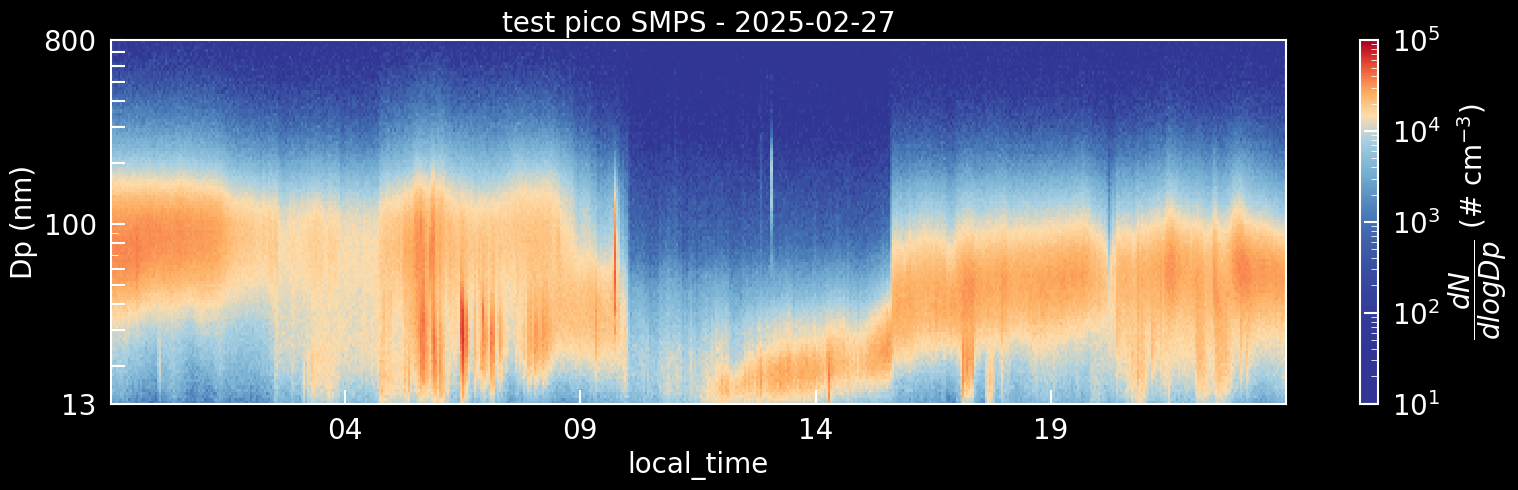

In [14]:
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap = warp_colormap(base_cmap, high_end_bias)

# --- Data setup ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])
dfp['date'] = dfp['local_time'].dt.date

# Meshgrid setup (once, reused)
Time = pd.to_datetime(dfp['local_time'])
X = mdates.date2num(Time)
Y = mid_Dp.copy()
XX, YY = np.meshgrid(X, Y)
Z = dNdlogDp_stpp.copy().T
Z_all = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))

# --- Daily plot loop ---
plot_counter = 0
grouped = dfp.groupby('date')



os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

for date, group in grouped:
    day_mask = dfp['date'] == date
    x_day = X[day_mask]
    z_day = Z_all[:, day_mask]

    fig, ax1 = plt.subplots(figsize=(16, 5))
    pcm = ax1.pcolormesh(x_day, YY[:, :z_day.shape[1]], z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=1e5)) # jt

    cbar = fig.colorbar(pcm, ax=ax1)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')    

    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)

    # Custom y-tick locations and labels
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))

    ax1.set_ylabel('Dp (nm)')
    ax1.set_xlabel('local_time')
    ax1.tick_params(axis='both', which='major')

    ax1.xaxis.set_major_formatter(DateFormatter('%H'))
    ax1.set_xlim(x_day[0], x_day[-1])
    
    ax1.set_title(f'test pico SMPS - {date}')    

    plt.tight_layout()

    # Save only once here
    filename = os.path.join(output_folder, f'pico_time_series_{date}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory, no need to call plt.show()

    plot_counter += 1

print(f'Number of days plotted: {plot_counter}')

# Plot with 4 time series in the top plots and their respective N_stps in the lower plots

/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_65244/3959396756.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


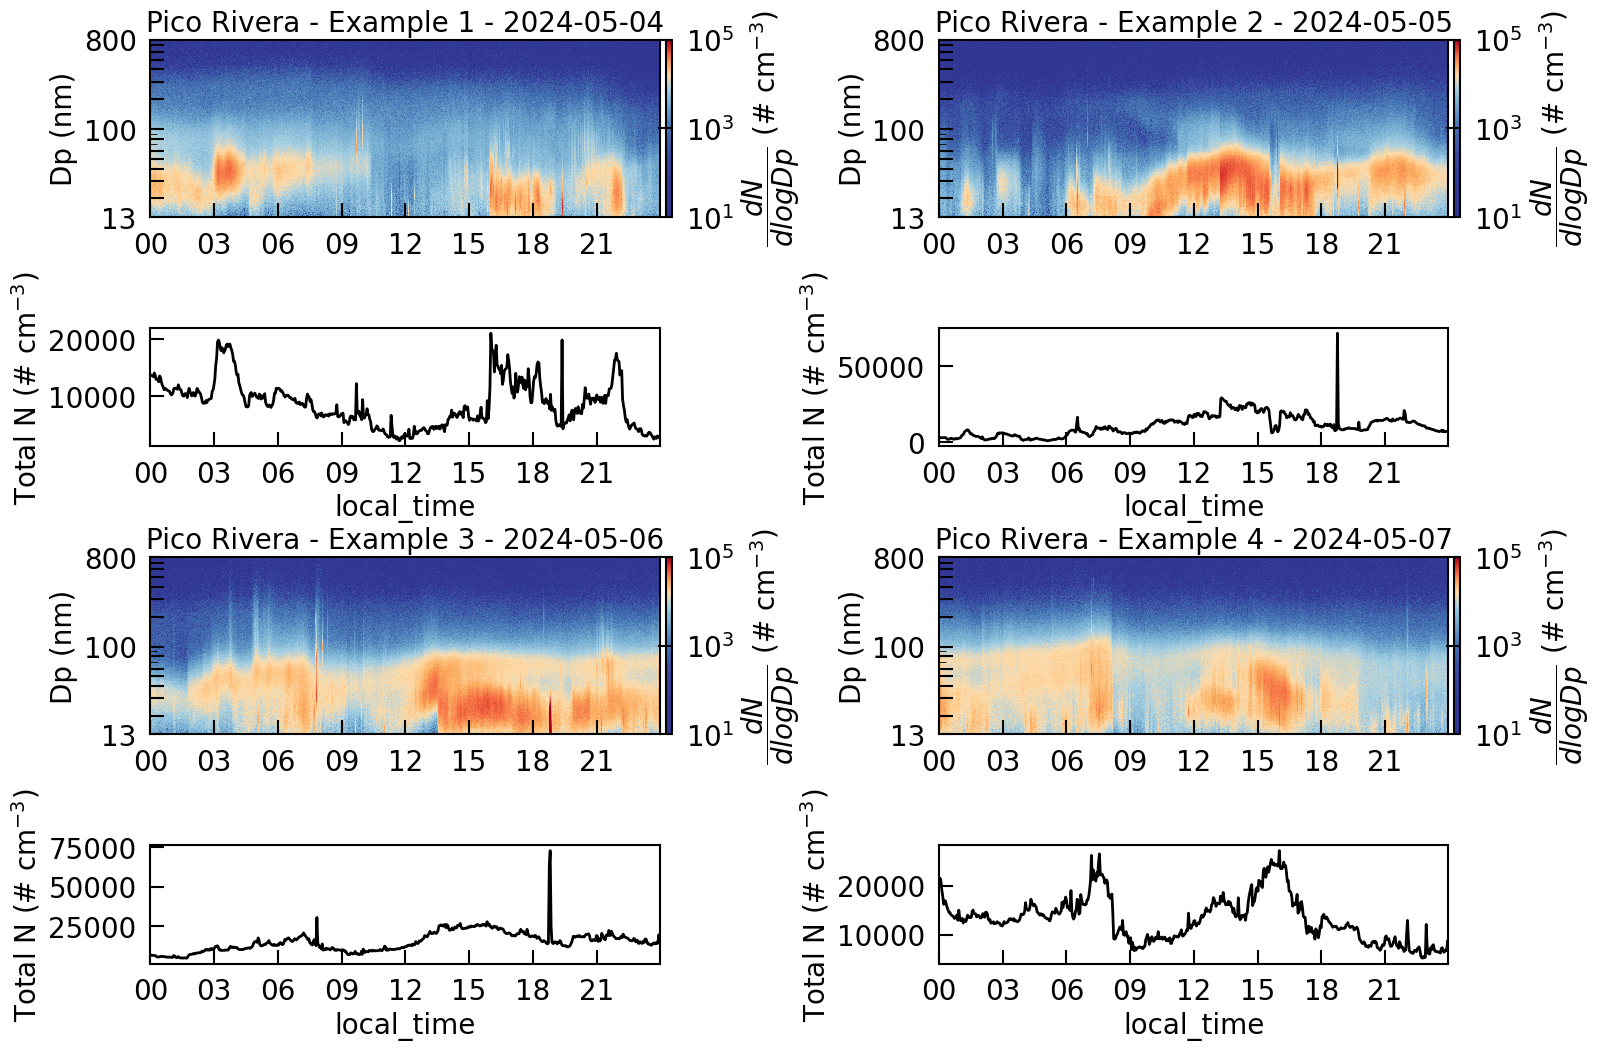

In [159]:
# Move to other code, keep this one too 
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3


# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

custom_cmap = warp_colormap(base_cmap, high_end_bias)




def get_day_data(df, Z_all, mid_Dp, date_str):
    date = pd.to_datetime(date_str).date()
    df = df.copy()
    df['local_time'] = pd.to_datetime(df['local_time'])
    df['date'] = df['local_time'].dt.date

    mask = df['date'] == date

    if mask.sum() == 0:
        raise ValueError(f"No data found for date {date_str} in the dataframe.")

    df_day = df[mask]
    X = mdates.date2num(df_day['local_time'])

    z_day = Z_all[:, mask.values]  # Use .values to index numpy array

    return X, mid_Dp, z_day, df_day
# Define which days and sites to show
plot_info = [
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-04', 'Pico Rivera - Example 1', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-05', 'Pico Rivera - Example 2', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-06', 'Pico Rivera - Example 3', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-07', 'Pico Rivera - Example 4', 1e5),
]



fig = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 2, height_ratios=[3, 2, 3, 2], hspace=0.75, wspace=0.3)

for i, (df, Z, mid_D, date, name, vmax) in enumerate(plot_info):
    Z_masked = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))
    X, Y, z_day, df_day = get_day_data(df, Z_masked, mid_D, date)

    col_row = 0 if i < 2 else 2
    col_col = i % 2

    start = pd.to_datetime(date + ' 00:00')
    end = pd.to_datetime(date + ' 23:59')

    # meshgrid for pcolormesh
    XX, YY = np.meshgrid(X, Y)

    # --- Colormap plot ---
    ax1 = fig.add_subplot(gs[col_row, col_col])
    pcm = ax1.pcolormesh(XX, YY, z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=vmax))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'{name} - {date}')

    def log_tick_formatter(val, pos=None):
        exponent = int(np.log10(val))
        return f'$10^{{{exponent}}}$'

    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    cbar.ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

    # --- Mean magnitude plot ---
    ax2 = fig.add_subplot(gs[col_row + 1, col_col], sharex=ax1)
    ax2.plot(df_day['local_time'], df_day['N_stp'], color='black', lw=2)
    ax2.set_ylabel('Total N (# cm$^{-3}$)')

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlim(start, end)

    ax2.set_xlabel('local_time')


    # Align bottom plot width to top plot width
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])


plt.tight_layout(rect=[0, 0, 0.9, 1])
filename = os.path.join(output_folder, f'pico_4_panel_event_plot_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()


## Plot with time series with black carbon (30_min_avg) in bottom plot (1 figure per day)

In [25]:
# --- Data setup ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])
dfp['date'] = dfp['local_time'].dt.date

# Ensure dfp and SMPS are aligned
assert dfp.shape[0] == dNdlogDp_stpp.shape[0], "Mismatch between dfp and SMPS data!"

# Meshgrid setup (once, reused)
Time = pd.to_datetime(dfp['local_time'])
X = mdates.date2num(Time)
Y = mid_Dp.copy()
Z = dNdlogDp_stpp.copy().T  # Shape: (sizes, timestamps)
Z_all = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))

# --- Daily plot loop ---
plot_counter = 0
grouped = dfp.groupby('date')

os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

for date, group in grouped:
    # Mask for this date
    day_mask = dfp['date'] == date
    x_day = X[day_mask]
    z_day = Z_all[:, day_mask]

    if z_day.shape[1] == 0:
        continue

    black_carbon = dfp.loc[day_mask, '30_min_avg'].values

    start = pd.to_datetime(str(date) + ' 00:00')
    end = pd.to_datetime(str(date) + ' 23:59')

    # --- Create figure with two panels ---
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # --- Top: SMPS heatmap ---
    ax1 = fig.add_subplot(gs[0])
    XX, YY = np.meshgrid(x_day, Y)
    pcm = ax1.pcolormesh(XX, YY[:, :z_day.shape[1]], z_day,
                         shading='auto', cmap=custom_cmap,
                         norm=LogNorm(vmin=10, vmax=1e5))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)

    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'SMPS + Black Carbon - {date}')
    ax1.tick_params(axis='x', labelbottom=False)

    # Colorbar
    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    # --- Bottom: Black Carbon ---
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(dfp.loc[day_mask, 'local_time'], black_carbon, color='red', lw=2)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel('Black Carbon\n(µg/m³)')
    ax2.set_xlim(start, end)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlabel('local_time')

    # --- Align subplot widths ---
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])

    # Save figure
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    filename = os.path.join(output_folder, f'time_series_plot_with_bc_{date}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    plot_counter += 1

print(f'Number of days plotted: {plot_counter}')

/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_65244/2340467015.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


Number of days plotted: 63


# Average N_stp over whole dataset (Weekend Versus Weekday)

Pico Rivera Sample Weekday Dates (with weekday name):
2023-08-04 (Friday)
2023-08-07 (Monday)
2023-08-08 (Tuesday)
2023-08-09 (Wednesday)
2023-08-10 (Thursday)
2023-08-11 (Friday)
2023-08-14 (Monday)
2023-08-15 (Tuesday)
2023-08-16 (Wednesday)
2023-08-17 (Thursday)

Pico Rivera Sample Weekend Dates (with weekday name):
2023-08-05 (Saturday)
2023-08-06 (Sunday)
2023-08-12 (Saturday)
2023-08-13 (Sunday)
2023-08-19 (Saturday)
2023-08-20 (Sunday)
2023-08-26 (Saturday)
2023-08-27 (Sunday)
2023-09-02 (Saturday)
2023-09-03 (Sunday)


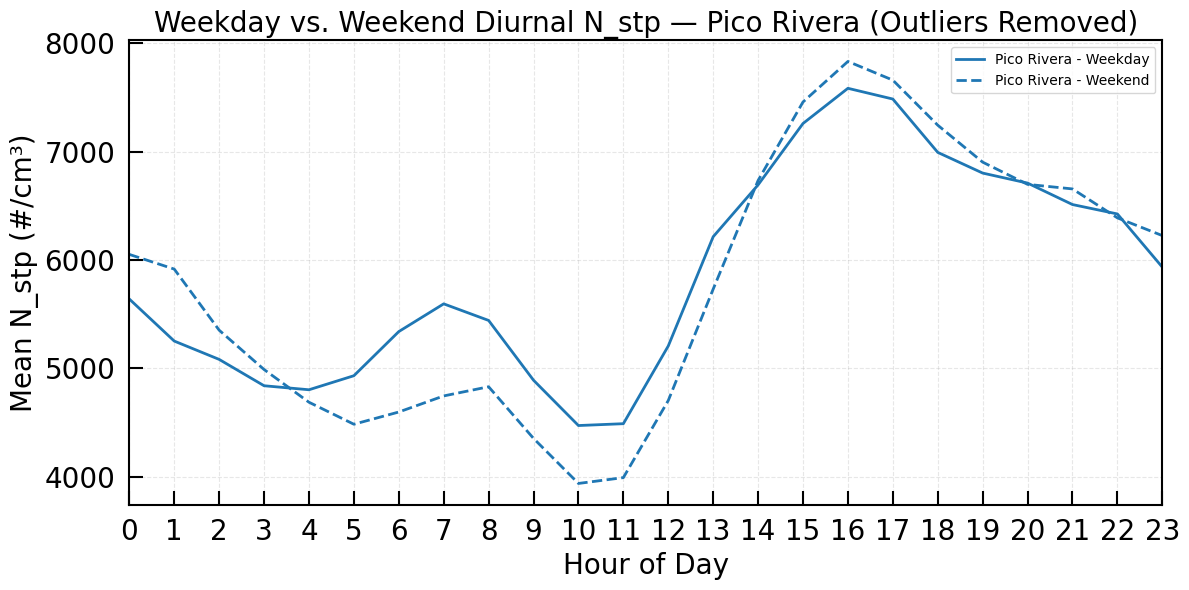

In [15]:
# Move to other code, keep this here
lower_p = dfp['N_stp'].quantile(0.01)
upper_p = dfp['N_stp'].quantile(0.99)
dfp_no_outliers = dfp[(dfp['N_stp'] >= lower_p) & (dfp['N_stp'] <= upper_p)].copy()

# Make sure hour and dayofweek columns exist in the filtered dataframes
for df in [dfp_no_outliers, dfp_no_outliers]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6
    
# Create weekday and weekend masks
weekday_mask_p = dfp_no_outliers['dayofweek'].isin(range(5))  # 0-4
weekend_mask_p = dfp_no_outliers['dayofweek'].isin([5,6])     # 5-6

# Group by hour and take mean N_stp for weekdays and weekends
weekday_p = dfp_no_outliers[weekday_mask_p].groupby('hour')['N_stp'].mean()
weekend_p = dfp_no_outliers[weekend_mask_p].groupby('hour')['N_stp'].mean()

#################
# After filtering and adding 'hour' and 'dayofweek' columns (dfp_no_outliers and dfp_no_outliers)...

# Print samples for Pico Rivera (dfp_no_outliers)
print("Pico Rivera Sample Weekday Dates (with weekday name):")
for d in dfp_no_outliers[weekday_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

print("\nPico Rivera Sample Weekend Dates (with weekday name):")
for d in dfp_no_outliers[weekend_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

#################

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(weekday_p.index, weekday_p, label='Pico Rivera - Weekday', color='tab:blue', linewidth=2)
plt.plot(weekend_p.index, weekend_p, label='Pico Rivera - Weekend', color='tab:blue', linestyle='--', linewidth=2)

plt.xlabel('Hour of Day')
plt.ylabel('Mean N_stp (#/cm³)')

plt.title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')

plt.legend()

plt.grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))  # Show all hours 0 through 23

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

## Average N_stp and BC (30_min_avg) over whole dataset (Weekend Versus Weekday)

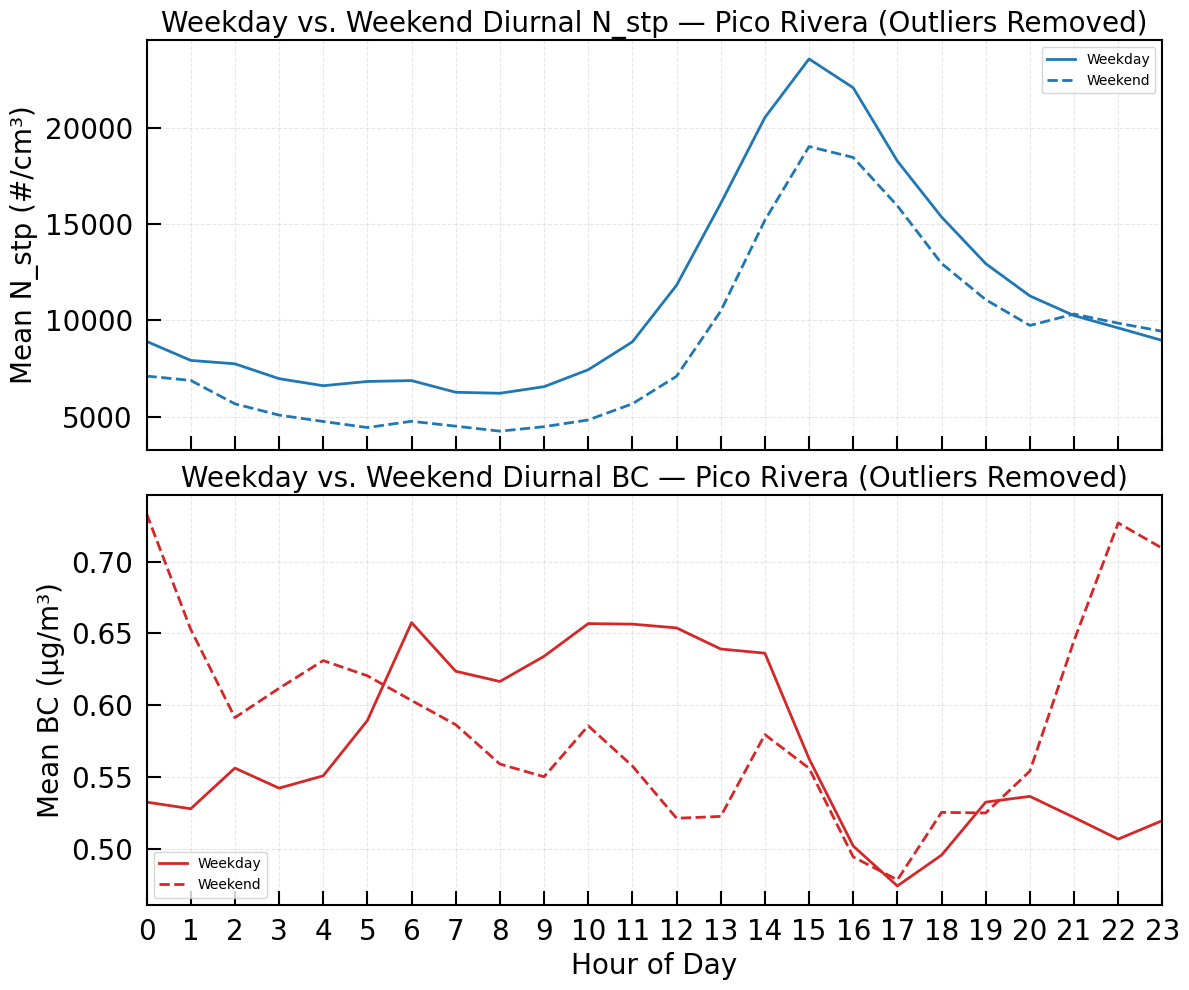

In [29]:
# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Remove outliers for N_stp and BC ---
df_nstp = remove_outliers(dfp, 'N_stp')
df_bc = remove_outliers(dfp, '30_min_avg')

# --- 3️⃣ Convert time column to datetime and extract hour/dayofweek ---
for df in [df_nstp, df_bc]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6

# --- 4️⃣ Weekday/weekend masks ---
weekday_mask_n = df_nstp['dayofweek'].isin(range(5))
weekend_mask_n = df_nstp['dayofweek'].isin([5,6])

weekday_mask_bc = df_bc['dayofweek'].isin(range(5))
weekend_mask_bc = df_bc['dayofweek'].isin([5,6])

# --- 5️⃣ Compute hourly means ---
weekday_nstp = df_nstp[weekday_mask_n].groupby('hour')['N_stp'].mean()
weekend_nstp = df_nstp[weekend_mask_n].groupby('hour')['N_stp'].mean()

weekday_bc = df_bc[weekday_mask_bc].groupby('hour')['30_min_avg'].mean()
weekend_bc = df_bc[weekend_mask_bc].groupby('hour')['30_min_avg'].mean()

# --- 6️⃣ Plot both variables in stacked subplots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# N_stp Plot
axes[0].plot(weekday_nstp.index, weekday_nstp, label='Weekday', color='tab:blue', linewidth=2)
axes[0].plot(weekend_nstp.index, weekend_nstp, label='Weekend', color='tab:blue', linestyle='--', linewidth=2)
axes[0].set_ylabel('Mean N_stp (#/cm³)')

axes[0].set_title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')

axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# BC Plot
axes[1].plot(weekday_bc.index, weekday_bc, label='Weekday', color='tab:red', linewidth=2)
axes[1].plot(weekend_bc.index, weekend_bc, label='Weekend', color='tab:red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Mean BC (µg/m³)')
axes[1].set_xlabel('Hour of Day')
axes[1].set_title('Weekday vs. Weekend Diurnal BC — Pico Rivera (Outliers Removed)')

axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp_BC_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()



# Event Frequency

- These are estimated frequencies, you will need to define your own how you wish

- Feel free to change the frequencies here and even the variable name from pico_freq, just be sure to change the varable name from pico_freq to the name you picked in this line: bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4')  


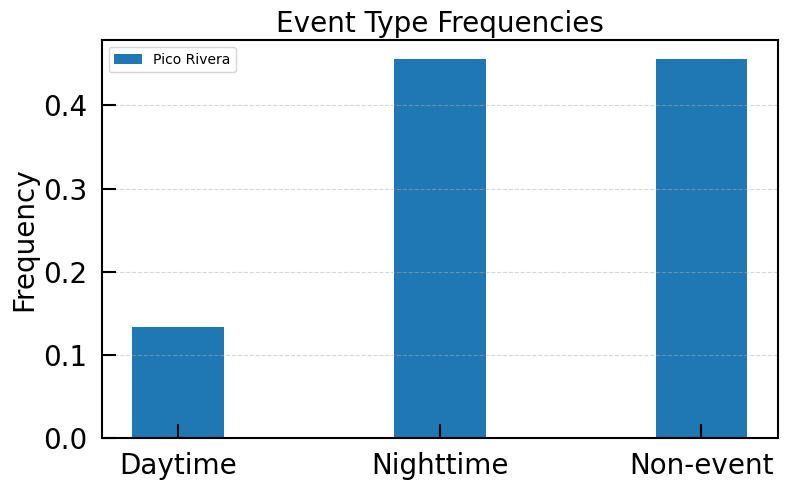

In [55]:
# Example data
event_types = ['Daytime', 'Nighttime', 'Non-event'] # these can have different names
pico_freq = [0.13333333333333333, 0.45555555555555555, 0.45555555555555555] # change the frequencies
x = np.arange(len(event_types))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4')

# Labels and styling
ax.set_ylabel('Frequency')
ax.set_title('Event Type Frequencies')
ax.set_xticks(x)
ax.set_xticklabels(event_types)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5, axis='y')

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_event_frequencies.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Average Particle size distributions

Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

Divide the dataset into day and night, and then calculate the average size distributions during those time periods for the whole dataset

In [16]:
df_copyp = tsdfp.copy()

In [17]:

df_copyp.columns[concentration_columns]

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Start with the taking the average dNdlogDp across all times for Pico Rivera and Rubidoux

In [18]:
# Change columns here if needed
selected_colsp = df_copyp.columns[concentration_columns]
bin_diametersp = np.array(selected_colsp).astype(float)
dNdlogDp_stpp_numeric = np.array(dNdlogDp_stpp, dtype='float')
# Mask out bins with all NaNs
valid_binsp = ~np.all(np.isnan(dNdlogDp_stpp_numeric), axis=0)

# Compute average across time for valid bins
mean_spectrum_p = np.nanmean(dNdlogDp_stpp_numeric[:, valid_binsp], axis=0)
bin_diameters_validp = bin_diametersp[valid_binsp]


## Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

In [19]:
df_copyp = df_copyp.reset_index()

In [20]:
df_copyp

,local_time,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),...,81.31,82.79,84.29,85.82,87.38,88.96,90.58,92.22,93.90,95.60
0,2023-08-04 12:17:36,1.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.01000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-04 12:21:41,2.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.01000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-04 12:24:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-04 12:27:39,1.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.01000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-04 12:30:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431266,2025-08-25 14:25:02,10794.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.60000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431267,2025-08-25 14:27:34,10795.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.60000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431268,2025-08-25 14:30:05,10796.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.60000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431269,2025-08-25 14:32:37,10797.00000,NaN,NaN,NaN,0.01000,NaN,0.60000,0.30000,0.60000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Convert timestamp column to datetime, if not already
df_copyp['local_time'] = pd.to_datetime(df_copyp['local_time'])

# Extract hour
df_copyp['hour'] = df_copyp['local_time'].dt.hour

In [22]:
# Daytime: 09:00–20:00
day_maskp = df_copyp['hour'].between(9, 20)

# Nighttime: 21:00–23:59 and 00:00–08:59
night_maskp = ~day_maskp  # everything else

In [23]:
# Convert dNdlogDp_stpp to numeric if not already done
dNdlogDp_stpp_numeric = pd.DataFrame(dNdlogDp_stpp).apply(pd.to_numeric, errors='coerce').values

# Apply masks to get subsets
dNdlogDp_dayp = dNdlogDp_stpp_numeric[day_maskp.values]
dNdlogDp_nightp = dNdlogDp_stpp_numeric[night_maskp.values]

In [24]:
mean_dayp = np.nanmean(dNdlogDp_dayp, axis=0)
mean_nightp = np.nanmean(dNdlogDp_nightp, axis=0)

## Plot the total and day/night averages on same figure

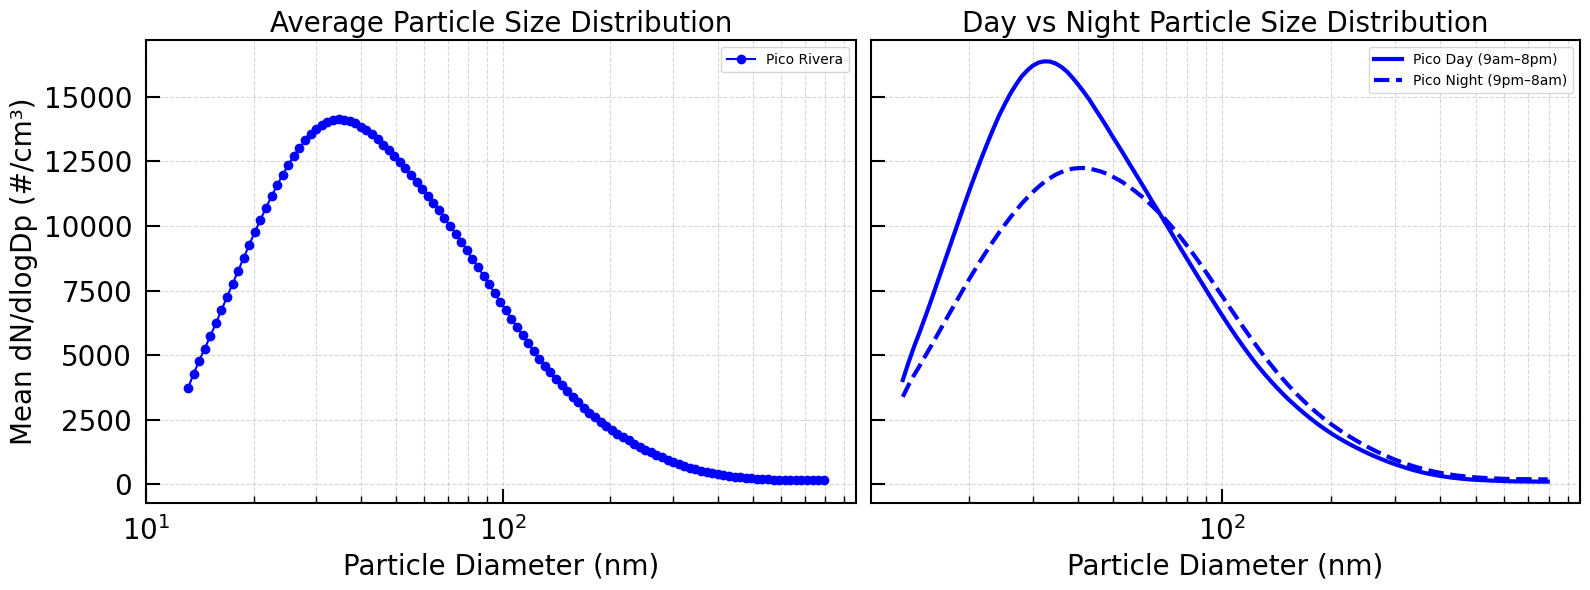

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 cols, share y-axis

# First subplot: Average size distribution comparison
axes[0].plot(bin_diameters_validp, mean_spectrum_p, marker='o', label='Pico Rivera', color='blue')


axes[0].set_xscale('log')
axes[0].set_xlabel('Particle Diameter (nm)')
axes[0].set_ylabel('Mean dN/dlogDp (#/cm³)')
axes[0].set_title('Average Particle Size Distribution')

axes[0].tick_params(axis='both', which='major')

axes[0].grid(True, which='both', linestyle='--', alpha=0.5)
axes[0].set_xticks([10, 100])

axes[0].legend()


# Second subplot: Day vs Night for both sites
axes[1].plot(bin_diameters_validp, mean_dayp, label='Pico Day (9am–8pm)', color='blue', linewidth=3)
axes[1].plot(bin_diameters_validp, mean_nightp, label='Pico Night (9pm–8am)', color='blue', linestyle='--', linewidth=3)

axes[1].set_xscale('log')
axes[1].set_xlabel('Particle Diameter (nm)')
axes[1].set_title('Day vs Night Particle Size Distribution')
axes[1].tick_params(axis='both', which='major')

axes[1].grid(True, which='both', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_day_vs_night_dNdlogDp.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## Average Total Number Concentration per Weekday

C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_38648\1182524675.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp['weekday'] = dfp.index.day_name()


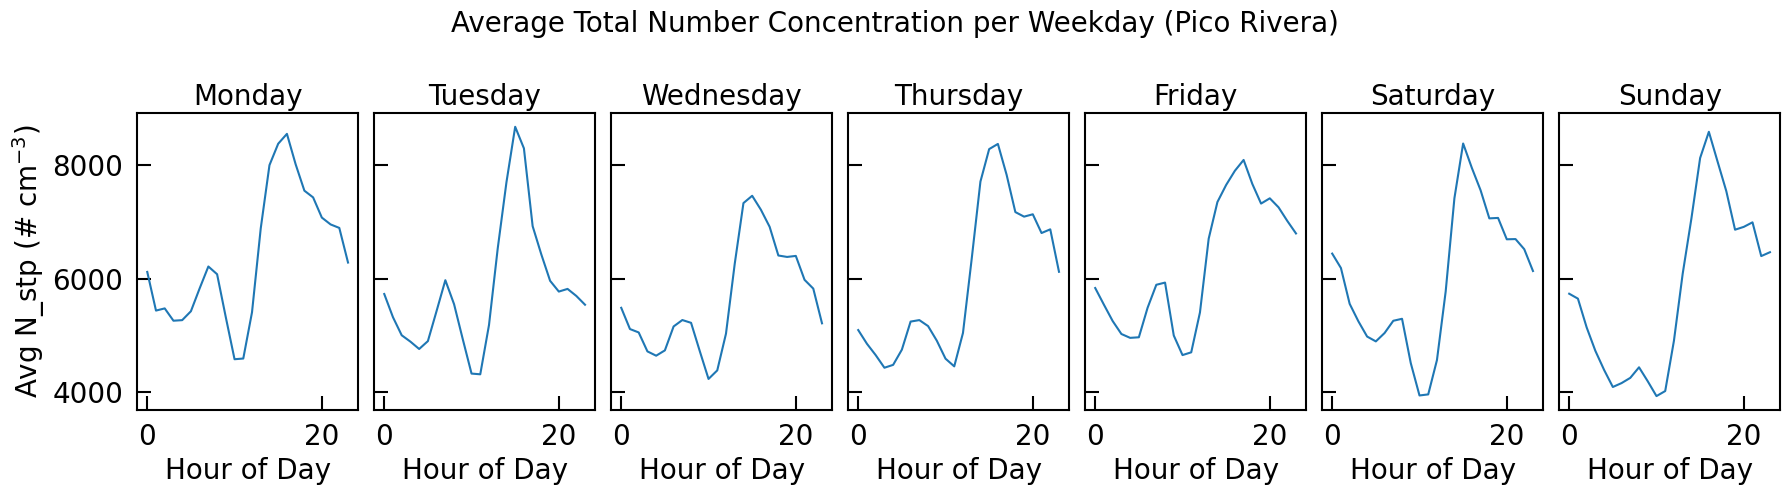

In [26]:
dfp['local_time'] = pd.to_datetime(dfp['local_time'], errors='coerce')
dfp = dfp.set_index('local_time')
dfp = dfp.dropna(subset=['N_stp'])
dfp['weekday'] = dfp.index.day_name()

# Remove outliers using z-score
dfp_copy = dfp.copy()
dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['N_stp'].astype(float), nan_policy='omit')) < 3]

# Define ordered weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a list of (weekday, DataFrame) tuples in order
weekday_groups = [(day, dfp_copy[dfp_copy['weekday'] == day]) for day in ordered_days]

# Plot setup
fig, axs = plt.subplots(1, 7, figsize=(18, 5), sharey=True)
axs = axs.flatten()

for i, (day, group) in enumerate(weekday_groups):
    avg_diurnal = group.groupby(group.index.hour)['N_stp'].mean()
    axs[i].plot(avg_diurnal.index, avg_diurnal.values)
    axs[i].set_title(day)
    axs[i].set_xlabel('Hour of Day')

    if i == 0:
        axs[i].set_ylabel('Avg N_stp (# cm$^{-3}$)')

# Final plot formatting
plt.suptitle('Average Total Number Concentration per Weekday (Pico Rivera)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
filename = os.path.join(output_folder, f'pico_avg_N_stp_per_weekday.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## N_stp averaged and BC over days of the week for the whole dataset

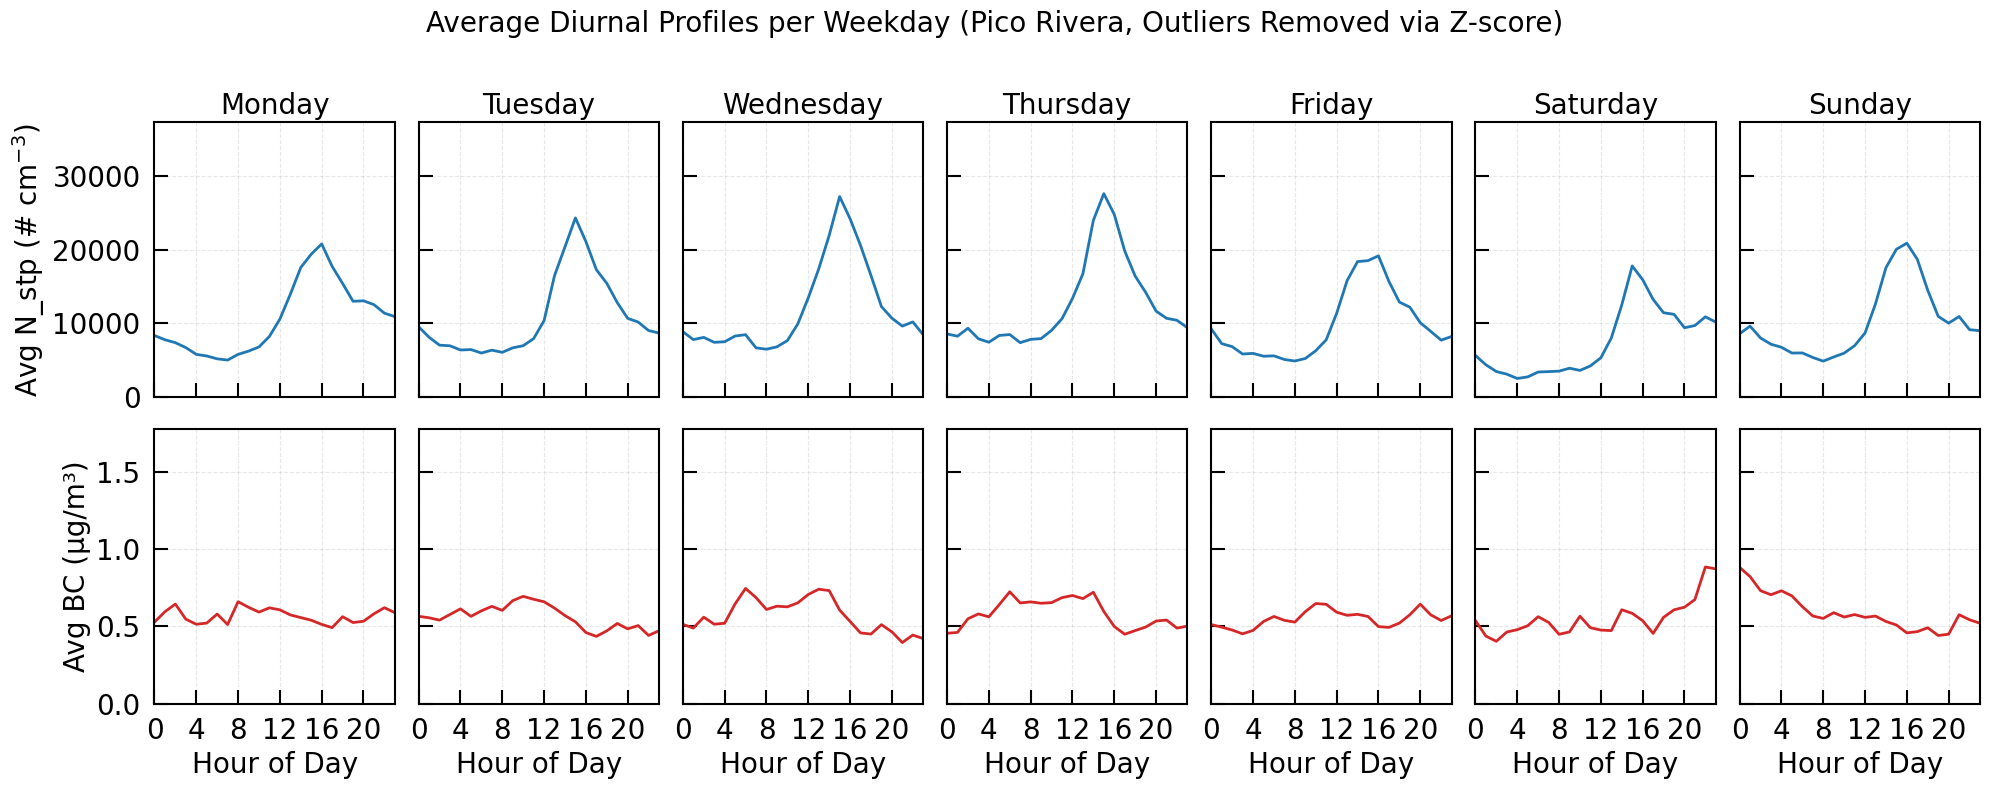

In [44]:
# --- 1️⃣ Copy dfp to avoid SettingWithCopy warnings ---

# --- 2️⃣ Remove outliers using z-score ---
dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['N_stp'].astype(float), nan_policy='omit')) < 3]
if '30_min_avg' in dfp_copy.columns:
    dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['30_min_avg'].astype(float), nan_policy='omit')) < 3]

# --- 3️⃣ Ensure datetime index and add weekday ---
if not isinstance(dfp_copy.index, pd.DatetimeIndex):
    dfp_copy.index = pd.to_datetime(dfp_copy.index, errors='coerce')

dfp_copy['weekday'] = dfp_copy.index.day_name()

# --- 4️⃣ Define weekday order ---
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# --- 5️⃣ Create weekday groups ---
weekday_groups = [(day, dfp_copy[dfp_copy['weekday'] == day]) for day in ordered_days]

# --- 6️⃣ Plot setup: 2 rows, shared y per row ---
fig, axs = plt.subplots(2, 7, figsize=(20, 8), sharex=True, sharey='row')
axs = axs.reshape(2, 7)

hours = range(24)  # x-axis for hours

# --- Row 1: N_stp ---
for i, (day, group) in enumerate(weekday_groups):
    if not group.empty:
        avg_diurnal = group.groupby(group.index.hour)['N_stp'].mean()
        axs[0, i].plot(avg_diurnal.index, avg_diurnal.values, color='tab:blue', linewidth=2)
    axs[0, i].set_title(day)
    axs[0, i].set_xlim(0, 23)
    axs[0, i].set_xticks(range(0, 24, 4))
    if i == 0:
        axs[0, i].set_ylabel('Avg N_stp (# cm$^{-3}$)')
    axs[0, i].grid(True, linestyle='--', alpha=0.3)

# Optional: set a reasonable y-limit for N_stp
axs[0, 0].set_ylim(0, dfp_copy['N_stp'].max() * 1.1)

# --- Row 2: 30_min_avg ---
for i, (day, group) in enumerate(weekday_groups):
    if '30_min_avg' in group.columns and not group.empty:
        avg_diurnal_bc = group.groupby(group.index.hour)['30_min_avg'].mean()
        axs[1, i].plot(avg_diurnal_bc.index, avg_diurnal_bc.values, color='tab:red', linewidth=2)
    axs[1, i].set_xlim(0, 23)
    axs[1, i].set_xticks(range(0, 24, 4))
    if i == 0:
        axs[1, i].set_ylabel('Avg BC (µg/m³)')
    axs[1, i].grid(True, linestyle='--', alpha=0.3)

# Optional: set a reasonable y-limit for BC
axs[1, 0].set_ylim(0, dfp_copy['30_min_avg'].max() * 1.1)

# --- 7️⃣ Final formatting ---
for ax in axs[1, :]:
    ax.set_xlabel('Hour of Day')

fig.suptitle('Average Diurnal Profiles per Weekday (Pico Rivera, Outliers Removed via Z-score)')

plt.tight_layout(rect=[0, 0, 1, 0.95])

filename = os.path.join(output_folder, 'pico_avg_N_stp_BC_per_weekday.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Average dNdlogDp per Hour

C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_38648\1911015403.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp_filtered['hour'] = dfp_filtered.index.hour
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_38648\1911015403.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo')


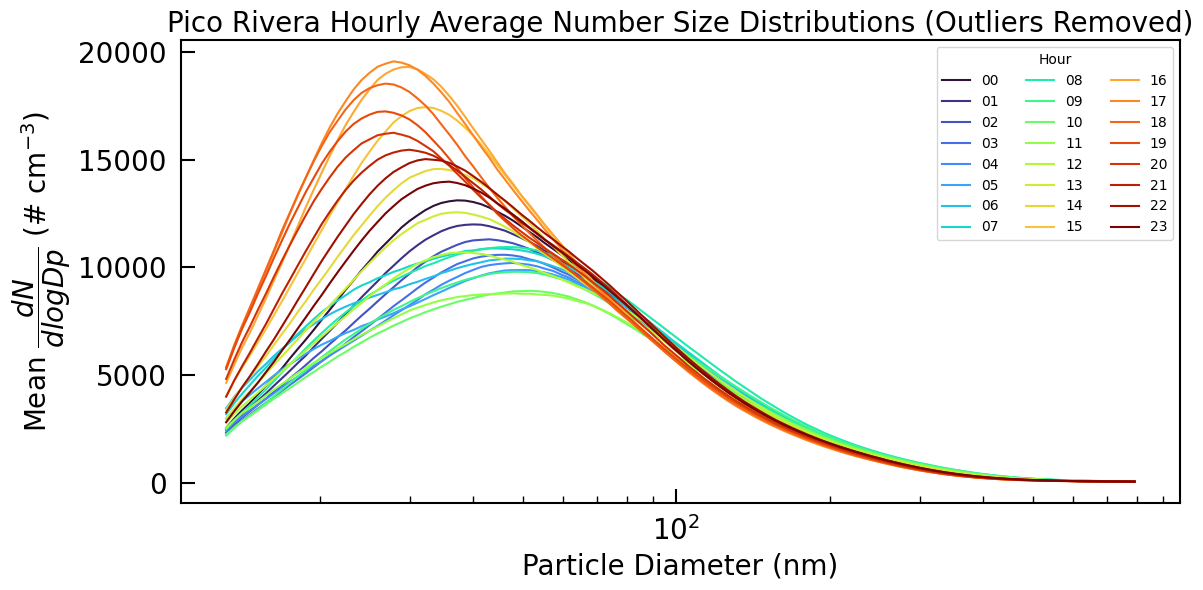

In [27]:
# Convert to float array
dNdlogDp_stpp = np.asarray(dNdlogDp_stpp, dtype=float)

# Step 1: Calculate z-scores across columns (bins)
z_scores = np.abs(zscore(dNdlogDp_stpp, axis=0, nan_policy='omit'))

# Step 2: Keep only rows where all bins are < 3 std dev
outlier_mask = (z_scores < 3).all(axis=1)

# Step 3: Filter both the data and the datetime index
dNdlogDp_filtered = dNdlogDp_stpp[outlier_mask]
dfp_filtered = tsdfp[outlier_mask]

# Step 4: Add hour column and group by hour
dfp_filtered.index = pd.to_datetime(dfp_filtered.index)
dfp_filtered['hour'] = dfp_filtered.index.hour

df_number = pd.DataFrame(dNdlogDp_filtered, index=dfp_filtered['hour'])
hourly_avgp = df_number.groupby(df_number.index).mean()  # shape: (24, n_bins)

# Step 5: Plot with turbo colormap
cmap = cm.get_cmap('turbo')

plt.figure(figsize=(12, 6))
for hr in range(24):
    color = cmap(hr / 23)  # normalize hour → [0, 1]
    plt.plot(bin_diametersp, hourly_avgp.iloc[hr], label=f'{hr:02d}', color=color)

plt.xscale('log')
plt.xlabel('Particle Diameter (nm)')
plt.ylabel('Mean $\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')
plt.title('Pico Rivera Hourly Average Number Size Distributions (Outliers Removed)')
plt.legend(ncol=3, title='Hour')

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_avg_dNdlogDp_per_hour.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Reset Index

In [173]:
dfp = dfp.reset_index()

# Growth Rate Calculation

Preliminary, calculates GR in nm/hr using the geometric mean diameter (Geo. Mean (nm)):

[Geo. Mean (nm) at Time 2 - Geo. Mean (nm) at Time 1] / [Time 2 - Time 1]

In [48]:
def add_growth_rate_column(dfp, time_col='local_time', diam_col='Geo. Mean (nm)', max_gap_min=3):
    """
    Adds a growth rate column (nm/hr) to the DataFrame by computing
    the slope between each point and the next valid point (gap ≤ max_gap_min).
    """
    df = dfp.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Initialize growth rate column
    growth_rates = np.full(len(df), np.nan)
    
    for i in range(len(df) - 1):
        dt = (df[time_col].iloc[i+1] - df[time_col].iloc[i]).total_seconds() / 60  # in minutes
        if dt <= max_gap_min and dt > 0:
            dD = df[diam_col].iloc[i+1] - df[diam_col].iloc[i]  # diameter change (nm)
            growth_rates[i] = dD / (dt / 60)  # convert to nm/hr
    
    df['growth_rate_nm_hr'] = growth_rates
    return df

# --- Example usage ---
dfp = add_growth_rate_column(dfp, time_col='local_time', diam_col='Geo. Mean (nm)')

## Average N_stp, BC, and GR in June, July

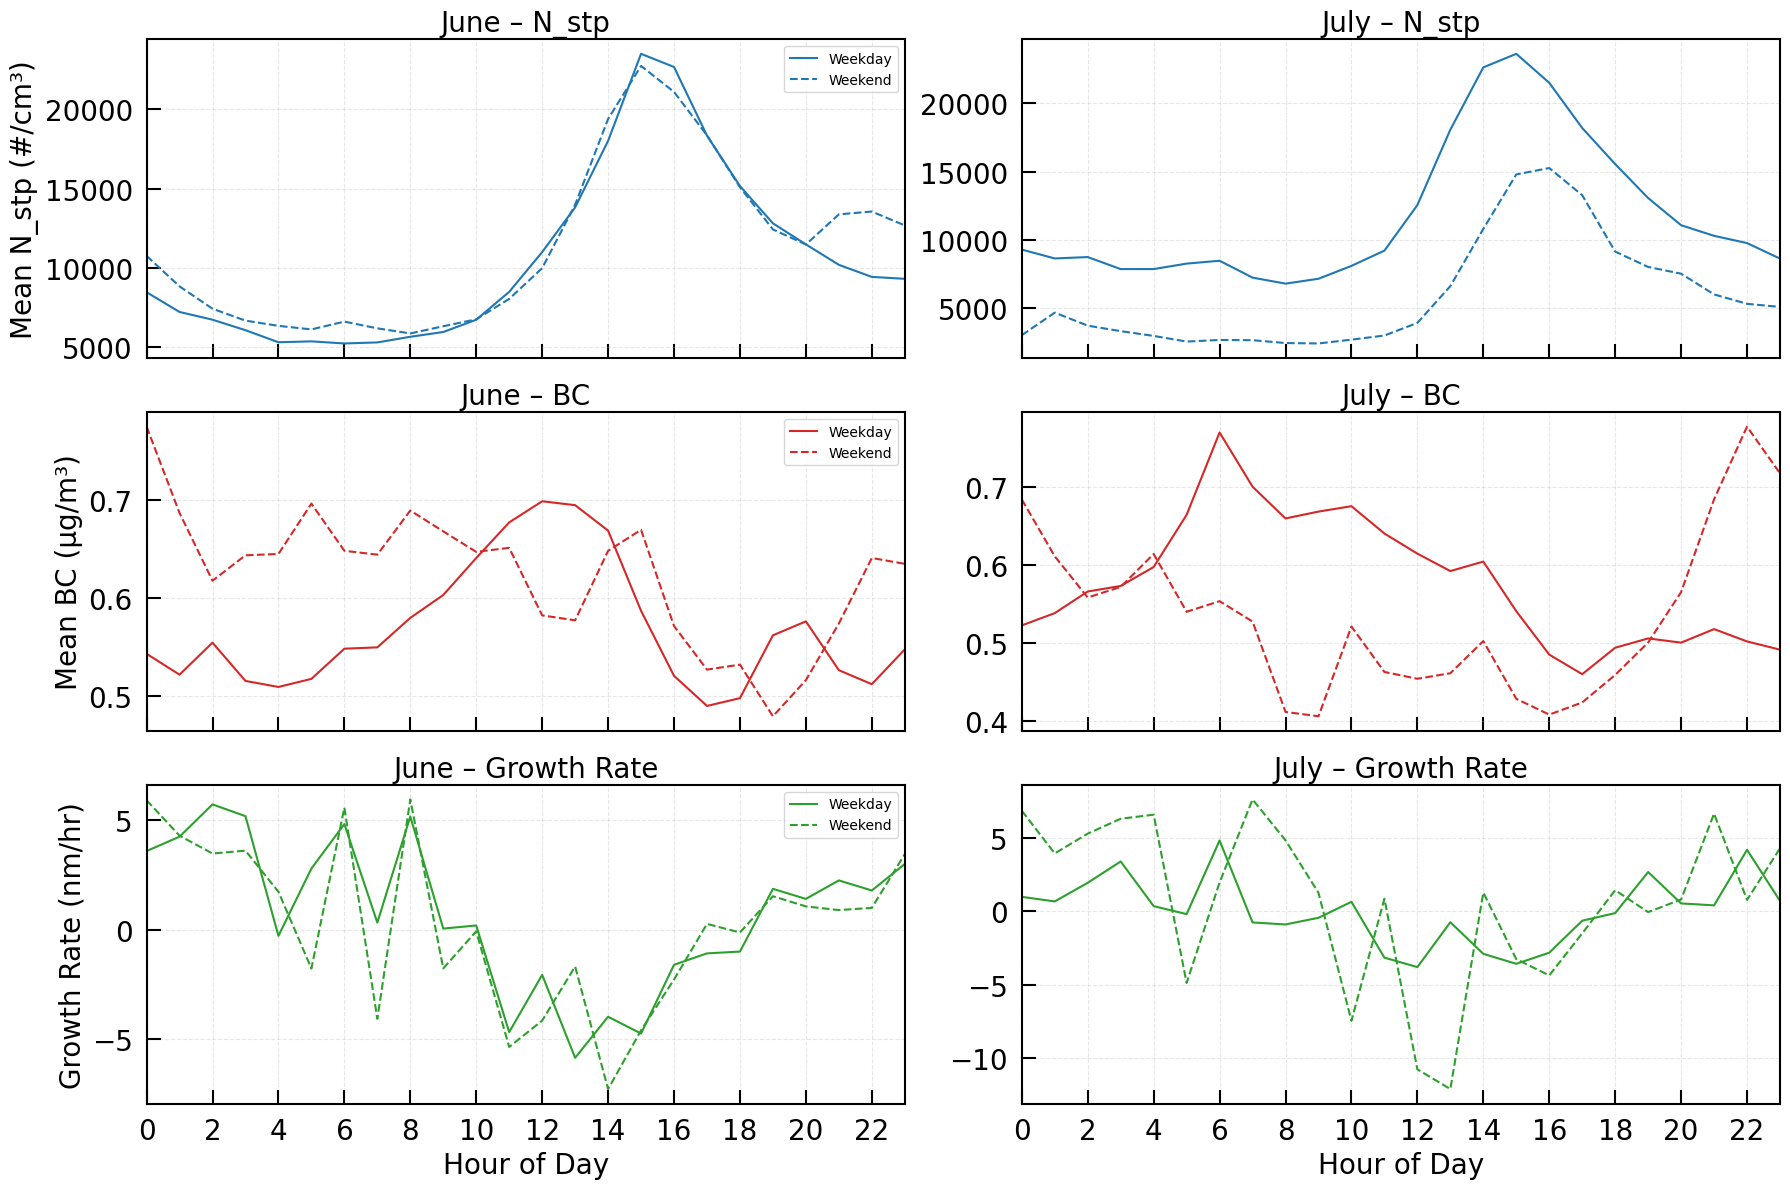

In [54]:
# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Remove outliers for N_stp, BC, and GR ---
df_nstp = remove_outliers(dfp, 'N_stp')
df_bc = remove_outliers(dfp, '30_min_avg')
df_gr = remove_outliers(dfp, 'growth_rate_nm_hr')

# --- 3️⃣ Convert time column to datetime and extract hour/dayofweek/month ---
for df in [df_nstp, df_bc, df_gr]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek
    df['month'] = df['local_time'].dt.month

# --- 4️⃣ Define months of interest ---
months = {6: 'June', 7: 'July'}

# --- 5️⃣ Create figure with 3 rows (N_stp, BC, GR) × 2 columns (months) ---
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

for idx, (month_num, month_name) in enumerate(months.items()):
    # --- Weekday/weekend masks ---
    weekday_n = (df_nstp['month'] == month_num) & df_nstp['dayofweek'].isin(range(5))
    weekend_n = (df_nstp['month'] == month_num) & df_nstp['dayofweek'].isin([5,6])
    
    weekday_bc = (df_bc['month'] == month_num) & df_bc['dayofweek'].isin(range(5))
    weekend_bc = (df_bc['month'] == month_num) & df_bc['dayofweek'].isin([5,6])
    
    weekday_gr = (df_gr['month'] == month_num) & df_gr['dayofweek'].isin(range(5))
    weekend_gr = (df_gr['month'] == month_num) & df_gr['dayofweek'].isin([5,6])
    
    # --- Hourly means ---
    weekday_nstp = df_nstp[weekday_n].groupby('hour')['N_stp'].mean()
    weekend_nstp = df_nstp[weekend_n].groupby('hour')['N_stp'].mean()
    
    weekday_bc_data = df_bc[weekday_bc].groupby('hour')['30_min_avg'].mean()
    weekend_bc_data = df_bc[weekend_bc].groupby('hour')['30_min_avg'].mean()
    
    weekday_gr_data = df_gr[weekday_gr].groupby('hour')['growth_rate_nm_hr'].mean()
    weekend_gr_data = df_gr[weekend_gr].groupby('hour')['growth_rate_nm_hr'].mean()

    # --- Plot N_stp ---
    axes[0, idx].plot(weekday_nstp.index, weekday_nstp, label='Weekday', color='tab:blue')
    axes[0, idx].plot(weekend_nstp.index, weekend_nstp, label='Weekend', color='tab:blue', linestyle='--')
    axes[0, idx].set_title(f'{month_name} – N_stp')
    axes[0, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[0, idx].set_ylabel('Mean N_stp (#/cm³)')
        axes[0, idx].legend()

    # --- Plot BC ---
    axes[1, idx].plot(weekday_bc_data.index, weekday_bc_data, label='Weekday', color='tab:red')
    axes[1, idx].plot(weekend_bc_data.index, weekend_bc_data, label='Weekend', color='tab:red', linestyle='--')
    axes[1, idx].set_title(f'{month_name} – BC')
    axes[1, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[1, idx].set_ylabel('Mean BC (µg/m³)')
        axes[1, idx].legend()

    # --- Plot Growth Rate ---
    axes[2, idx].plot(weekday_gr_data.index, weekday_gr_data, label='Weekday', color='tab:green')
    axes[2, idx].plot(weekend_gr_data.index, weekend_gr_data, label='Weekend', color='tab:green', linestyle='--')
    axes[2, idx].set_title(f'{month_name} – Growth Rate')
    axes[2, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[2, idx].set_ylabel('Growth Rate (nm/hr)')
        axes[2, idx].legend()

# --- Shared X-axis settings ---
for ax in axes[2]:
    ax.set_xlabel('Hour of Day')
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_monthly.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


In [187]:
dfp

,local_time,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),...,82.79,84.29,85.82,87.38,88.96,90.58,92.22,93.90,95.60,N_stp
0,2023-08-04 12:17:36,1.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019878
1,2023-08-04 12:21:41,2.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019924
2,2023-08-04 12:24:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,2023-08-04 12:27:39,1.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019911
4,2023-08-04 12:30:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431266,2025-08-25 14:25:02,10794.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30824.383628
431267,2025-08-25 14:27:34,10795.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32720.794644
431268,2025-08-25 14:30:05,10796.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33291.991060
431269,2025-08-25 14:32:37,10797.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34218.250867


## Colormap time series plot of dNdlogDp_stp over the whole time period with the new, warped colormap

In [28]:
dNdlogDp_stpp.shape

(431271, 115)

In [29]:
# ---- Custom colormap warp ----
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Warp it
custom_cmap = warp_colormap(base_cmap, high_end_bias)

Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time.to_numpy())

Y = mid_Dp  # shape (115,)

Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape should be (115, len(X))

if Z.shape[1] != len(X):
    raise ValueError(f"Mismatch: Z has {Z.shape[1]} columns, X has {len(X)} timestamps")

XX, YY = np.meshgrid(X, Y)
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())


# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')


# X-axis ticks every 15 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')


plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_warped_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


KeyError: 'local_time'

## Same Plot but for longer time periods:

In [30]:
# ---- Custom colormap warp ----
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Warp it
custom_cmap = warp_colormap(base_cmap, high_end_bias)

Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time.to_numpy())

Y = mid_Dp  # shape (115,)

Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape should be (115, len(X))

if Z.shape[1] != len(X):
    raise ValueError(f"Mismatch: Z has {Z.shape[1]} columns, X has {len(X)} timestamps")

XX, YY = np.meshgrid(X, Y)
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())


# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')


# X-axis ticks every 60 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')


plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_warped_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


KeyError: 'local_time'

## Colormap time series plot of dNdlogDp_stp over the whole time period with the old colormap

In [31]:
# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# ---- Prepare data for pcolormesh ----
Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time)           # numeric time for pcolormesh
Y = mid_Dp.copy()                   # particle diameters
XX, YY = np.meshgrid(X, Y)          # 2D mesh
Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape must be (len(Y), len(X))
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())

# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')

# X-axis ticks every 15 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')

plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_old_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


KeyError: 'local_time'